# Traiter plus de données

Le [notebook d'example](./01-muon-eta-distribution.ipynb) n'utilisait que les 10000 premiers événements d'un fichier de données. Vous verrez qu'il ne s'agit que d'une petite fraction des données. Pour mettre au point vos différents code une telle fraction sera sans doute suffisante (et permet de faire des "explorations" rapides des données), mais tôt ou tard il vous faudra passer sur plus de données. 

Pour ce faire il faut être capable de boucler sur les données. Etre capable de le faire rapidement est un bonus appréciable.

## Traitement par lots

Pour "boucler" on travaille "par lot" grâce à la fonction `iterate` de `uproot`. 

> "boucler" est entre guillements car vous verrez que l'analyse en python est efficace si l'on utilise ce que l'on appelle le "array programming", c'est-à-dire qu'il faut prendre l'habitude de travailler sur des tableaux plutôt que sur des valeurs uniques (ce que l'on appelle également _vectoriser_).

Comme dans le notebook d'example, nous analysons un fichier de données récupéré sur Cernbox 

In [3]:
import uproot
import awkward as ak
import numpy as np
import math
import hist

In [4]:
run=290297
file = uproot.open(f"/pbs/throng/training/nantes-m2-rps-exp/data/run{run}.data.root")
events = file["eventsTree"]

Au contraire du notebook d'exemple, nous allons cette fois-ci analyser _toutes_ les données de ce fichier, mais par lot (de 10000 événements = `step_size`) grâce à la fonction `iterate` de `uproot` :

In [5]:
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    print(len(m),len(m[ak.where(m.nMuons>1)]))

10000 541
10000 513
10000 511
10000 540
10000 520
10000 570
10000 537
10000 517
10000 512
10000 495
10000 560
10000 533
10000 550
10000 557
10000 530
10000 538
10000 525
10000 533
10000 492
10000 559
10000 565
10000 550
10000 497
10000 525
10000 539
10000 550
10000 513
10000 548
10000 520
4828 242


On définit comme précédemment quelques fonctions pour calculer la pseudo-rapidité :

In [6]:
def mag(px:float,py:float,pz:float):
    """Returns the norm of the 3-vector (px,py,pz)."""
    return math.sqrt(px*px+py*py+pz*pz)

def costheta(px:float,py:float,pz:float):
    """Returns the cos(theta) of the 3 vector (px,py,pz)."""
    ptot = mag(px,py,pz);
    return 1.0 if ptot == 0.0 else pz/ptot

def eta(px:float,py:float,pz:float):
    """Returns the pseudo-rapidity of the 3 vector (px,py,pz)."""
    ct = costheta(px,py,pz)
    if ct*ct < 1:
        return -0.5* math.log( (1.0-ct)/(1.0+ct) )
    if pz == 0: 
        return 0
    if pz>0: 
        return 10E10
    else:
        return -10E20

Au lieu de créer un tableau unique de grande taille avec toutes les valeurs de $\eta$ (comme on l'a fait ci-dessus) _puis_ de faire un histogramme de ces valeurs, on peut créer _d'abord_ un histogramme puis le remplir au fur et à mesure du traitement par lot.

In [7]:
import hist
hEta = hist.Hist(hist.axis.Regular(bins=100,start=-6,stop=0,name='$\eta$'))

In [8]:
nofTracks=0 
nofEvents=0  
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    for event in m[m.nMuons>0]:
        nofEvents+=1
        tracks = event["Muon"].to_list()
        for t in tracks:
            nofTracks+=1
            hEta.fill(eta(t["Px"],t["Py"],t["Pz"]))
print(nofEvents,nofTracks)

146847 163912


Le module `hist` offre une fonction `plot` qui permet de visualiser rapidement l'histogramme : 

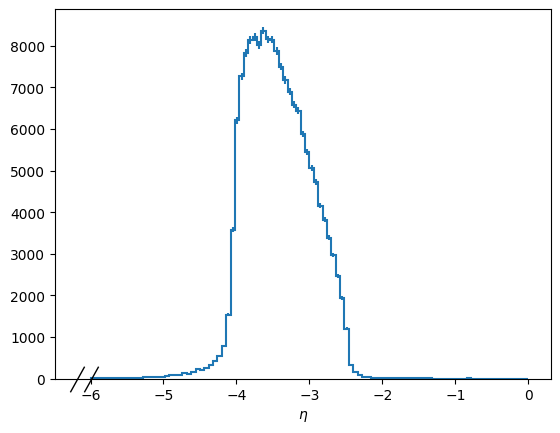

In [9]:
hEta.plot();

Et en utilisant `matplotlib` on peut configurer ce plot : 

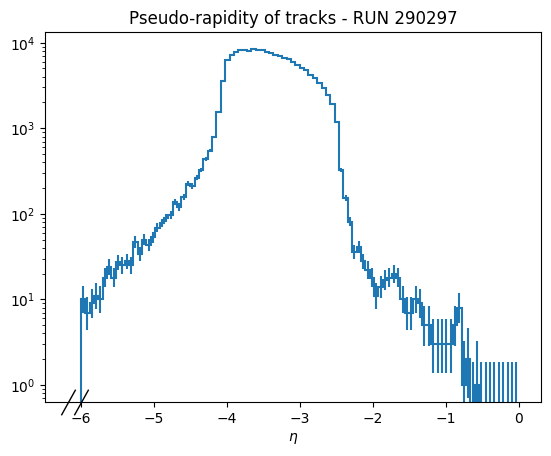

In [10]:
import matplotlib.pyplot as plt
hEta.plot()
plt.yscale("log")
plt.title(f"Pseudo-rapidity of tracks - RUN {run}");

## Vectorisation

> Cette partie n'est pas indispensable au bon déroulement du projet mais permet d'accéler les calculs et de commencer à vous familiariser avec une façon d'organiser les calculs habituelle dans le monde "data science / deep learning".

Si l'on reprend l'iteration sur les données on note qu'elle n'est pas particulièrement rapide :  

In [ ]:
%%time
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    for event in m[m.nMuons>0]:
        tracks = event["Muon"].to_list()
        for t in tracks:
            e = eta(t["Px"],t["Py"],t["Pz"])

Ceci est dû au fait que l'on calcule la pseudo-rapidité trace par trace (dans la fonction `Eta`) au lieu de faire des calculs sur des tableaux entiers. Essayons d'améliorer cela en commençant par le calcul de la norme de l'impulsion.

In [ ]:
%%time
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],how="zip",step_size=10000):
    for event in m[m.nMuons>0]:
        tracks = event["Muon"].to_list()
        for t in tracks:
            e = mag(t["Px"],t["Py"],t["Pz"])

On va remplacer le calcul sur un groupe de trois scalaires (px,py,pz) par un calcul sur trois vecteurs (px,py,pz) à l'aide de fonctions du module `numpy` (préfixées par `np.`) :

In [ ]:
def vmag(px,py,pz):
    """Returns an array of the norms of the 3-vectors (px,py,pz)."""
    return np.sqrt(px*px+py*py+pz*pz)

In [ ]:
%%time
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],step_size=10000):
    atLeastOneMuon = m.nMuons>0
    t = m[atLeastOneMuon]
    mag = vmag(t["Muon_Px"],t["Muon_Py"],t["Muon_Pz"])

Vous noterez que c'est bien plus rapide que la boucle initiale. Etendons cela au calcul de $\eta$ :

In [ ]:
def vcostheta(px,py,pz):
    """Returns an array of cos(theta) for the 3 vectors (px,py,pz)."""
    ptot = vmag(px,py,pz);
    return np.divide(pz,ptot)

def veta(px:float,py:float,pz:float):
    """Returns the pseudo-rapidity of the 3 vector (px,py,pz)."""
    ct = vcostheta(px,py,pz)
    return -0.5* np.log( (1.0-ct)/(1.0+ct) )

In [ ]:
vhEta = hist.Hist(hist.axis.Regular(bins=100,start=-6,stop=0,name='$\eta$'))

In [ ]:
%%time
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],step_size=10000):
    atLeastOneMuon = m.nMuons>0
    t = m[atLeastOneMuon]
    eta = veta(t["Muon_Px"],t["Muon_Py"],t["Muon_Pz"])
    vhEta.fill(ak.flatten(eta))

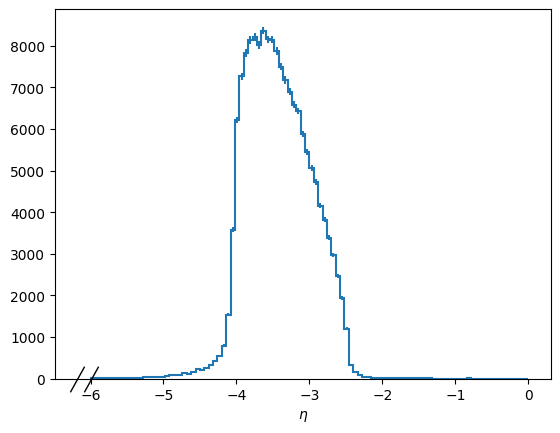

In [18]:
vhEta.plot();

# Experiments

In [35]:
def pT(t):
    return t["Pz"]/np.sinh(eta(t["Px"],t["Py"],t["Pz"]))

def invariant_mass(pT1,pT2,eta1,eta2,phi1,phi2):
    return np.sqrt(2*pT1*pT2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2)))

#def invariant_mass(E1,E2,p1,p2):
#    return np.sqrt(2*pT1*pT2*(np.cosh(eta1-eta2)-np.cos(phi1-phi2)))


def combinations(x):
    idx = np.stack(np.triu_indices(len(x), k=1), axis=-1)
    return x[idx]



array([[0, 1],
       [0, 2],
       [0, 3],
       [1, 2],
       [1, 3],
       [2, 3]])

In [40]:
%%time
for m in events.iterate(["nMuons","Muon_Px","Muon_Py","Muon_Pz","Muon_Charge"],step_size=10000):
    for ev in m[m.nMuons>=2][0:9]:
        #c = combinations(np.arange(ev.nMuons))
        ev.phi
        #invariant_mass()
        #print()
    #eta = veta(t["Muon_Px"],t["Muon_Py"],t["Muon_Pz"])
    #vhEta.fill(ak.flatten(eta))

AttributeError: no field named 'phi'